In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [2]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

Mounted at /content/drive


In [4]:
# path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [5]:
#### Droppa il primo caso e tiene il secondo con HBOND e VDW

#columns_to_check = df.columns[:-1]
#df_copy = df.copy()
#df = df.drop_duplicates(subset=columns_to_check, keep='last')

In [5]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [6]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

<ipython-input-6-1592439739>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [7]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [8]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [9]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

In [10]:
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  
1              0              1  
2       

## Feature engineering


### `a5` product

The `a5` feature measures the eletrostatic charge of the amino acids.

This new engineered features, computed as `s_a5 * t_a5`, is a good indicator for mainly predicting **IONIC** bond, it measures the residues' charge: A positively charged residue (K, R have high positive a5) interacts with a negatively charged one (D, E have high negative a5). The product will be a large negative number.

In [ ]:
X['a5_product'] = np.multiply(X['s_a5'], X['t_a5'])
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  \
0  ...  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0              3   
1  ...  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0              0   
2  ...  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0              2   
3  ... -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0              4   
4  ... -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0              0   

   t_ss8_encoded  a5_product  
0

### `a1` product

This new engineered features, computed as `s_a1 * t_a1`, is a good indicator for mainly predicting **VDW** and  bond, it measures polarity:
* A large positive product means either both are hydrophobic (- * - = +) or both are hydrophilic (+ * + = +).
* When combined with low RSA, a large positive a1_product strongly suggests a VDW interaction between two buried, hydrophobic residues.
* When combined with high RSA, it suggests a polar surface interaction, likely HBOND.

In [ ]:
X['a1_product'] = np.multiply(X['s_a1'], X['t_a1'])
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  \
0  ...  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0              3   
1  ...  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0              0   
2  ...  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0              2   
3  ... -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0              4   
4  ... -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0              0   

   t_ss8_encoded  a1_product  
0

### `rsa` sum

# sequence distance

In [11]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [13]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 675794
1: 471719
2: 24501
3: 22650
4: 5686
5: 1344
6: 1146
7: 697310


In [16]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")


Resampled y_bal distribution
0: 675794
1: 471719
2: 24501
3: 22650
4: 20000
5: 10000
6: 10000
7: 697310


## 2 - LOAD Existing data


In [ ]:
# X_bal = np.load(path + '/X_bal-SMOTE22.npy')
# y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [ ]:
# print('Original y_train distribution:', Counter(y_train))
# print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# # Count the class in X_bal
# unique_values, counts = np.unique(y_bal, return_counts=True)
# print(dict(zip(unique_values, counts)))

In [ ]:
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## XGBoost

Helper functions

In [13]:
def feature_importance(model, X_train, y_train, interaction_type):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'
  # UPDATE WITH NEW ENGINEERED FEATURES
  feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
          't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]
  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [14]:
def compute_metrics(y_test, y_pred, y_pred_prob):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.4f}')
  balanced_acc = balanced_accuracy_score(y_test, y_pred)
  print(f'Balanced Accuracy: {balanced_acc:.4f}')
  auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
  print(f'AUC-ROC: {auc_roc:.4f}')
  mcc = matthews_corrcoef(y_test, y_pred)
  print(f'Matthews Correlation Coefficient: {mcc:.4f}')
  average_precision = average_precision_score(y_test, y_pred_prob, average='weighted')
  print(f'Average Precision Score: {average_precision:.4f}')

In [15]:
def plot_confusion_matrix(y_test, y_pred, labels, interaction_type):
  cm = confusion_matrix(y_test, y_pred)
  labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
  cm_df = pd.DataFrame(cm, index=labels, columns=labels)

  #plot
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix for {interaction_type} interaction')
  plt.show()

### Train loop

Training classifier for Class 0
[0]	validation-auc:0.62954
[100]	validation-auc:0.71654
[143]	validation-auc:0.71699

Binary Classification Report for Class 0
Accuracy: 0.6444
Balanced Accuracy: 0.6581


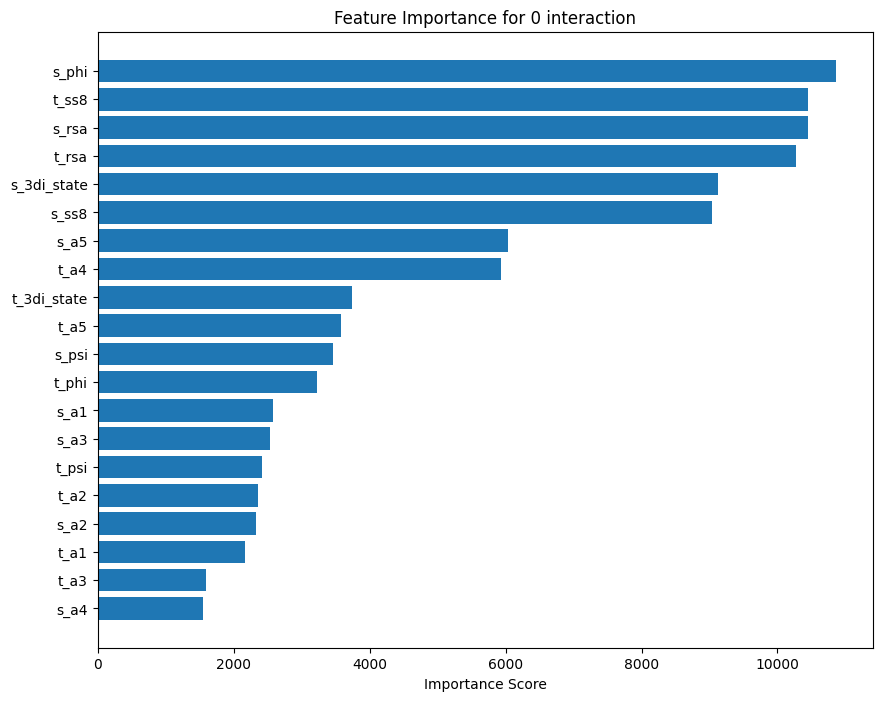

Training classifier for Class 1
[0]	validation-auc:0.54477
[42]	validation-auc:0.55318

Binary Classification Report for Class 1
Accuracy: 0.5296
Balanced Accuracy: 0.5378


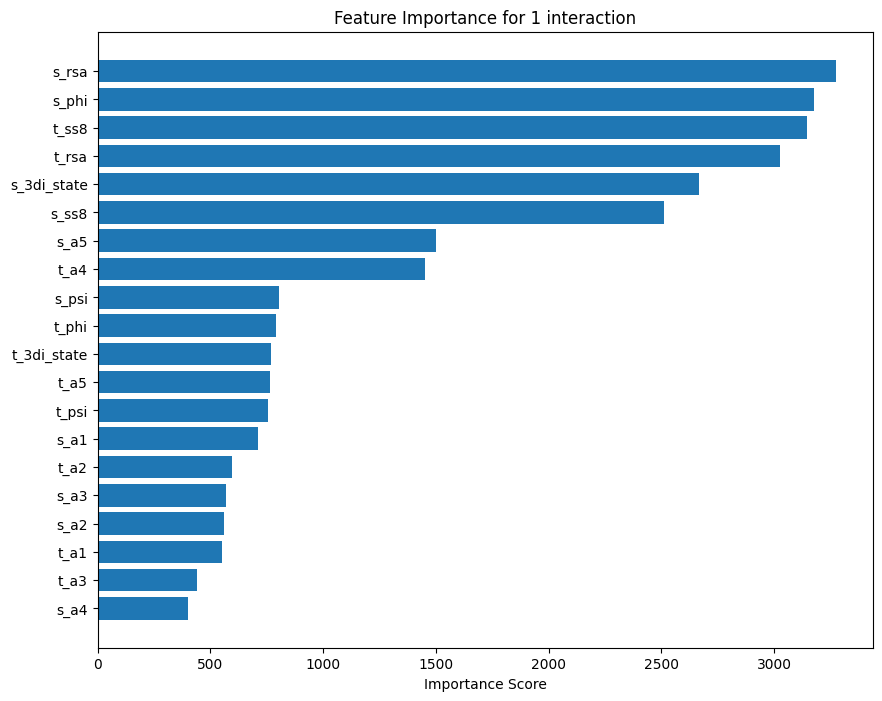

Training classifier for Class 2
[0]	validation-auc:0.99018
[58]	validation-auc:0.99089

Binary Classification Report for Class 2
Accuracy: 0.9791
Balanced Accuracy: 0.9871


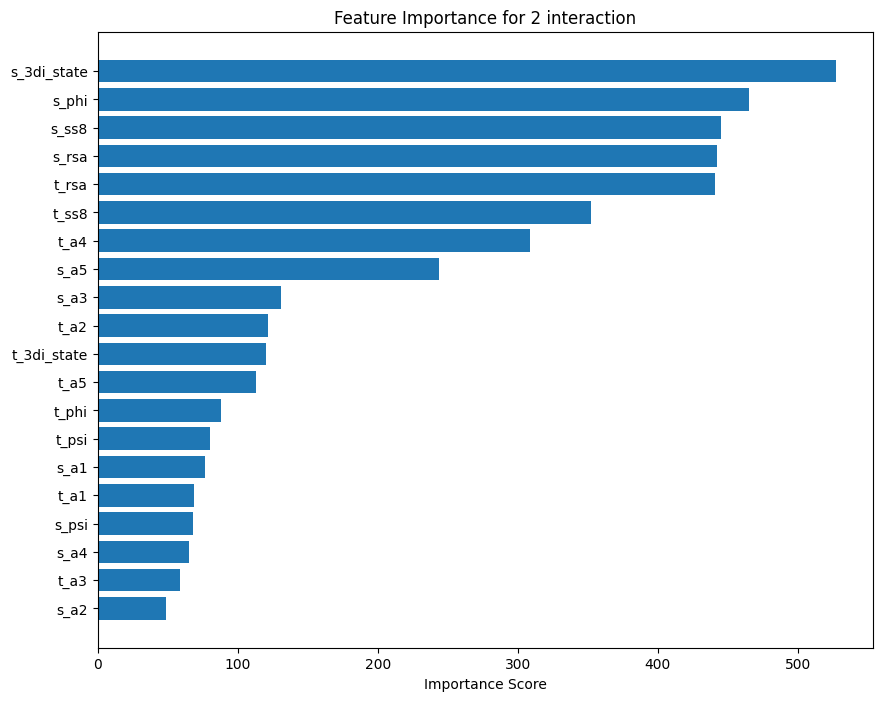

Training classifier for Class 3
[0]	validation-auc:0.97535
[49]	validation-auc:0.97745

Binary Classification Report for Class 3
Accuracy: 0.9417
Balanced Accuracy: 0.9632


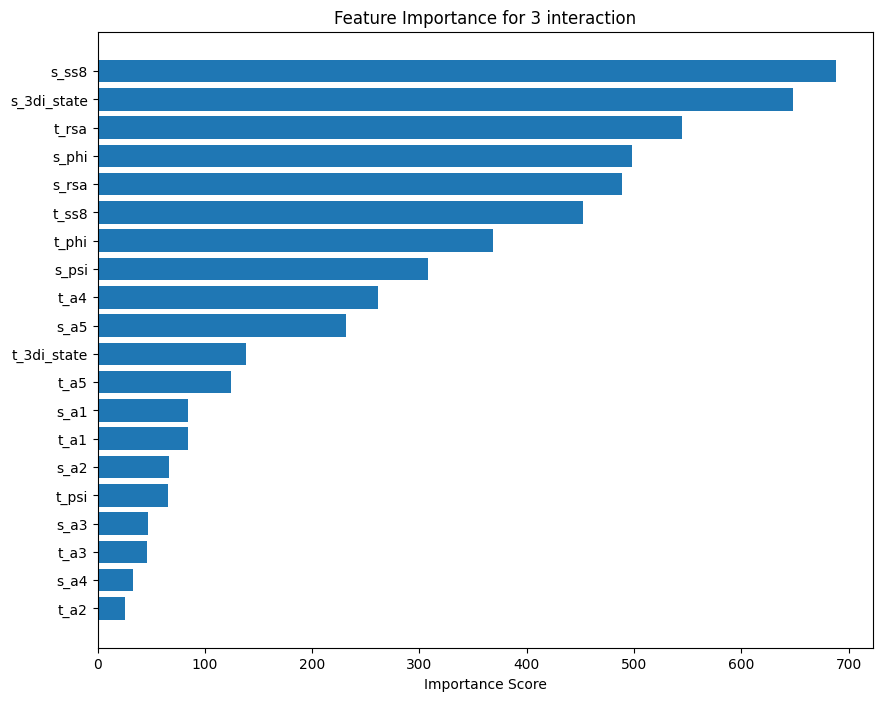

Training classifier for Class 4
[0]	validation-auc:0.97235
[61]	validation-auc:0.99025

Binary Classification Report for Class 4
Accuracy: 0.9780
Balanced Accuracy: 0.9522


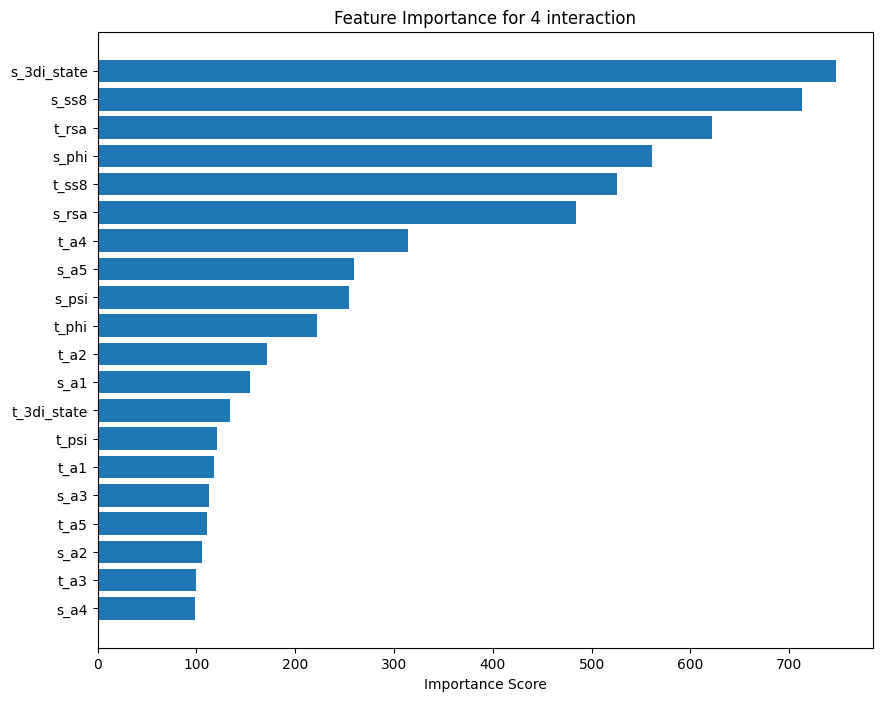

Training classifier for Class 5
[0]	validation-auc:0.99944
[37]	validation-auc:0.99951

Binary Classification Report for Class 5
Accuracy: 0.9990
Balanced Accuracy: 0.9852


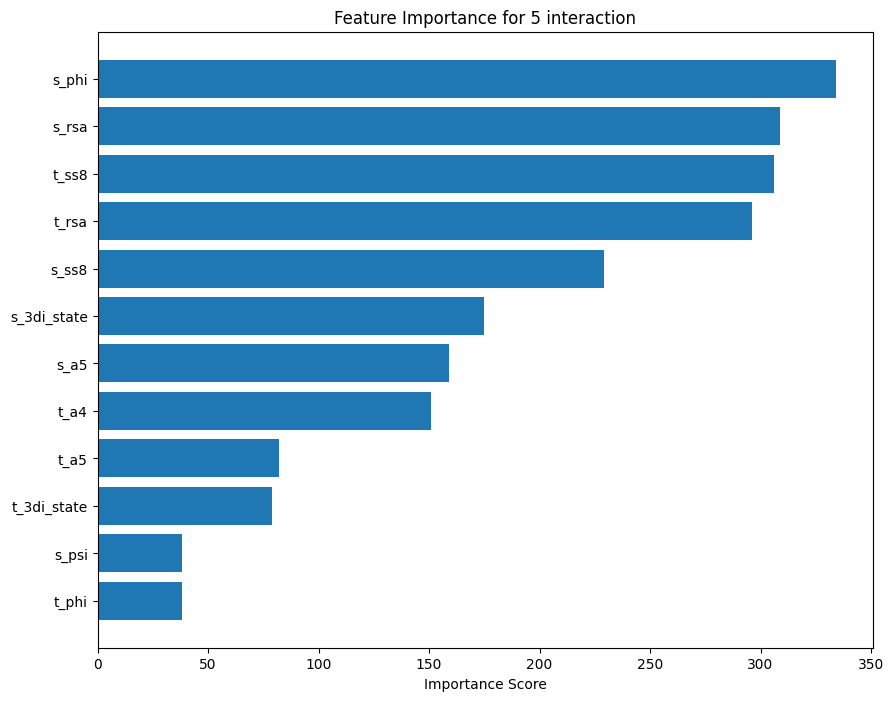

Training classifier for Class 6
[0]	validation-auc:0.94522
[19]	validation-auc:0.93729

Binary Classification Report for Class 6
Accuracy: 0.9248
Balanced Accuracy: 0.8842


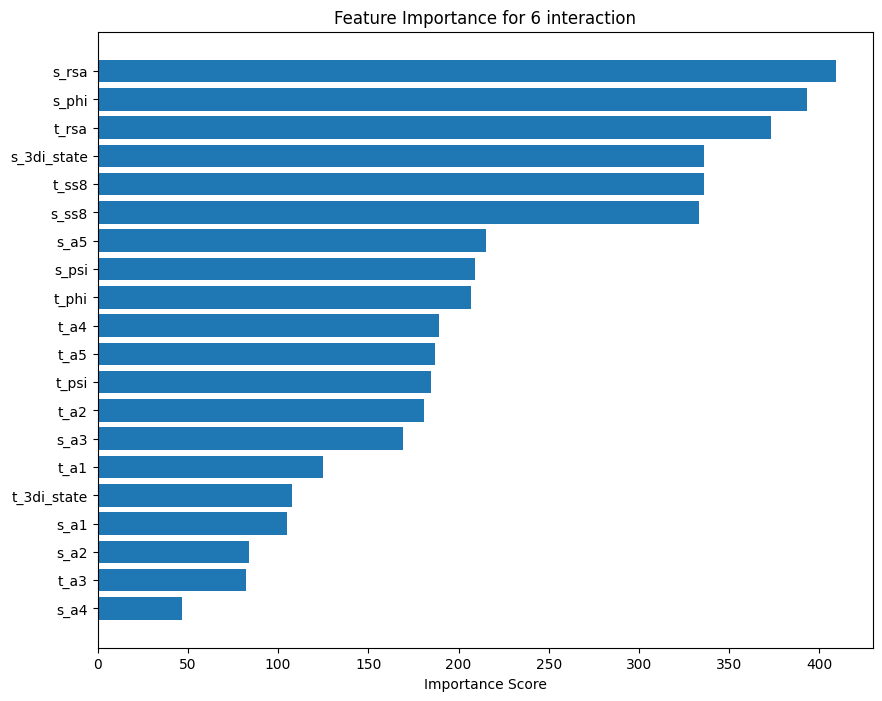

Training classifier for Class 7
[0]	validation-auc:0.65549
[100]	validation-auc:0.74382
[200]	validation-auc:0.75466
[300]	validation-auc:0.76071
[400]	validation-auc:0.76476
[500]	validation-auc:0.76795
[600]	validation-auc:0.77063
[700]	validation-auc:0.77319
[800]	validation-auc:0.77505
[900]	validation-auc:0.77683
[1000]	validation-auc:0.77841
[1100]	validation-auc:0.77963
[1200]	validation-auc:0.78107
[1300]	validation-auc:0.78205
[1400]	validation-auc:0.78309
[1500]	validation-auc:0.78421
[1600]	validation-auc:0.78516
[1700]	validation-auc:0.78627
[1800]	validation-auc:0.78709
[1900]	validation-auc:0.78783
[2000]	validation-auc:0.78844
[2100]	validation-auc:0.78914
[2200]	validation-auc:0.78972
[2300]	validation-auc:0.79046
[2400]	validation-auc:0.79105
[2499]	validation-auc:0.79148

Binary Classification Report for Class 7
Accuracy: 0.7326
Balanced Accuracy: 0.7101


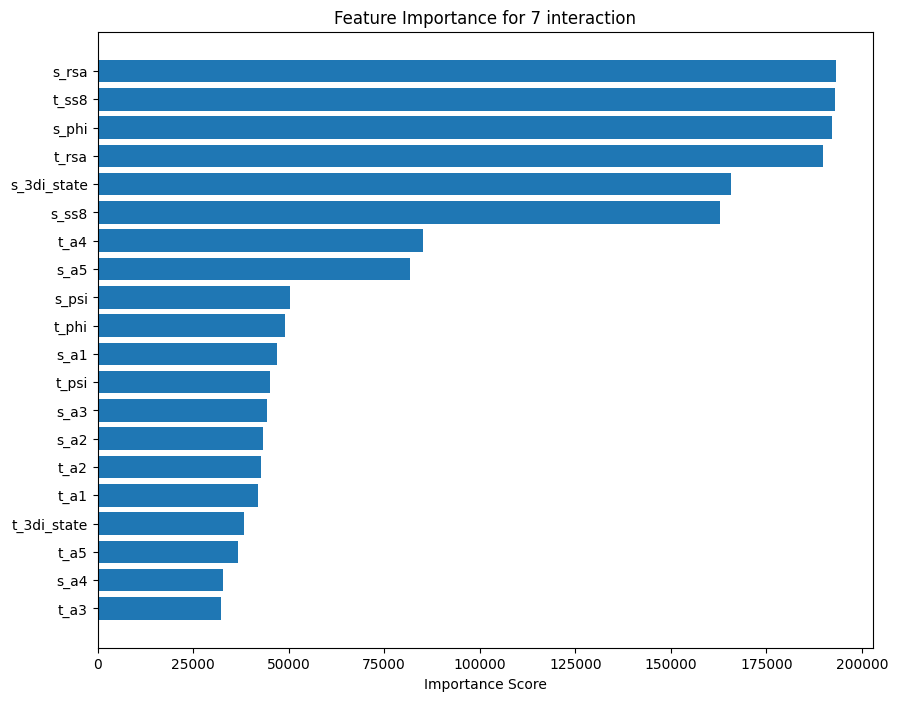

In [16]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))  # y_bal

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):  # y_bal
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int) # y_bal
    y_val_binary = (y_val == num_class).astype(int)

    # Binary labels for test data
    y_test_binary = (y_test == num_class).astype(int)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)
    dtest = xgb.DMatrix(X_test, label=y_test_binary)

    # Counte num positive/negative examples for this class
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)

    # Train model
    model = xgb.train(
        params = {
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.2,
            'scale_pos_weight': neg_class / pos_class if pos_class > 0 else 1.0,  # Handle class imbalance
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    #model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))

    # Store predictions for this class
    y_pred_prob = model.predict(dtest)
    all_class_predictions[:, num_class] = y_pred_prob

    # Evaluate this binary classifier
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(f"\nBinary Classification Report for Class {num_class}")
    print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_pred):.4f}")

    # Optional: Display feature importance for this classifier
    feature_importance(model, X_train, y_train_binary, num_class)

    # Store the model
    models.append(model)

# Final multi-class predictions (choose class with highest probability)
# final_predictions = np.argmax(all_class_predictions, axis=1)

# Evaluate overall multi-class performance
# print("\n==== Overall Multi-class Performance ====")
# compute_metrics(y_test, final_predictions, all_class_predictions)
# plot_confusion_matrix(y_test, final_predictions, np.unique(y))

## LightGBM

In [19]:
def feature_importance(model, X_train, y_train, interaction_type):
    # Get feature importance
    importance = model.feature_importance(importance_type='gain')  # 'split' or 'gain'
    # UPDATE WITH NEW ENGINEERED FEATURES
    feature_names = [
        's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

    # Create dictionary of feature importance
    importance_dict = dict(zip(feature_names, importance))

    # Sort the features by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
    plt.gca().invert_yaxis()  # To display the most important feature on top
    plt.show()

def compute_metrics(y_test, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    print(f'AUC-ROC: {auc_roc:.4f}')
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    average_precision = average_precision_score(y_test, y_pred_prob, average='weighted')
    print(f'Average Precision Score: {average_precision:.4f}')

def plot_confusion_matrix(y_test, y_pred, labels, interaction_type):
    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    #plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {interaction_type} interaction')
    plt.show()

Training classifier for Class 0
Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.678153
[100]	valid_0's auc: 0.689087
[150]	valid_0's auc: 0.695475
[200]	valid_0's auc: 0.699529
[250]	valid_0's auc: 0.702636
[300]	valid_0's auc: 0.7045
[350]	valid_0's auc: 0.706479
[400]	valid_0's auc: 0.707497
[450]	valid_0's auc: 0.70887
[500]	valid_0's auc: 0.710062
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.710062

Binary Classification Report for Class 0
Accuracy: 0.6336
Balanced Accuracy: 0.6522


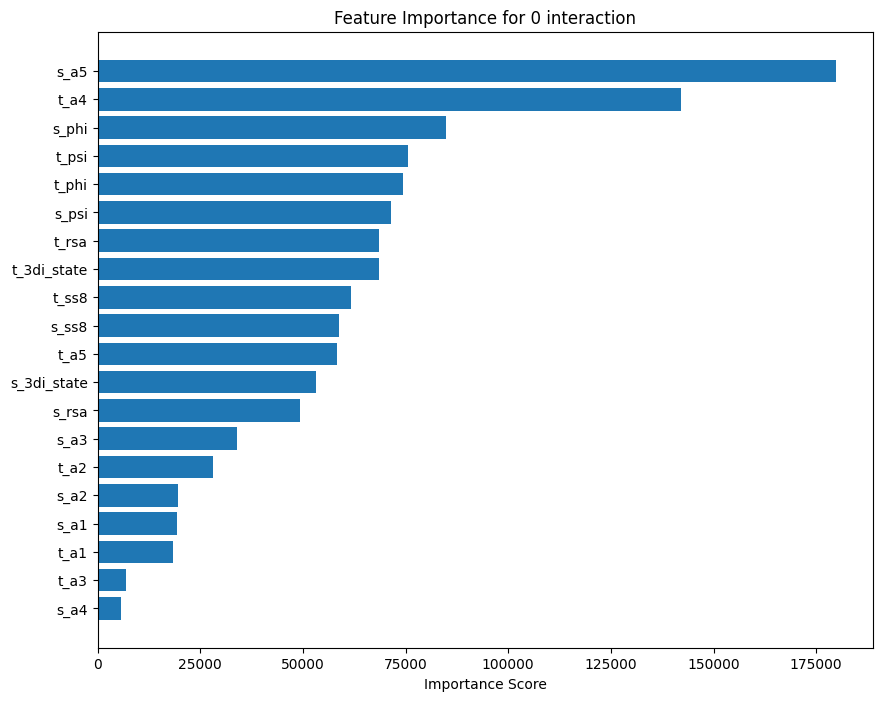

Training classifier for Class 1
Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.55751
[100]	valid_0's auc: 0.558507
Early stopping, best iteration is:
[129]	valid_0's auc: 0.558981

Binary Classification Report for Class 1
Accuracy: 0.5186
Balanced Accuracy: 0.5413


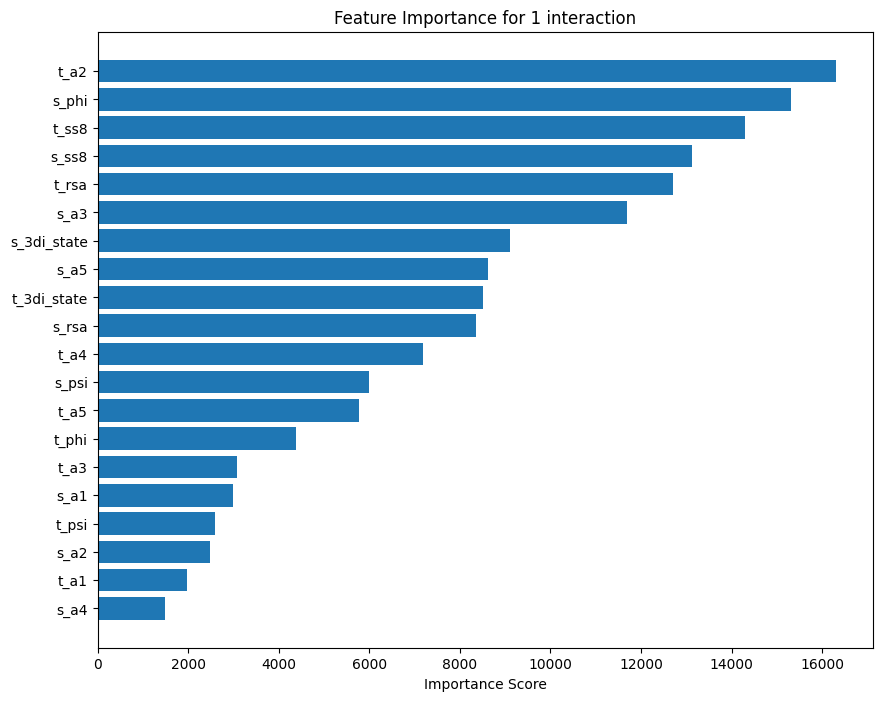

Training classifier for Class 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.989733

Binary Classification Report for Class 2
Accuracy: 0.9788
Balanced Accuracy: 0.9892


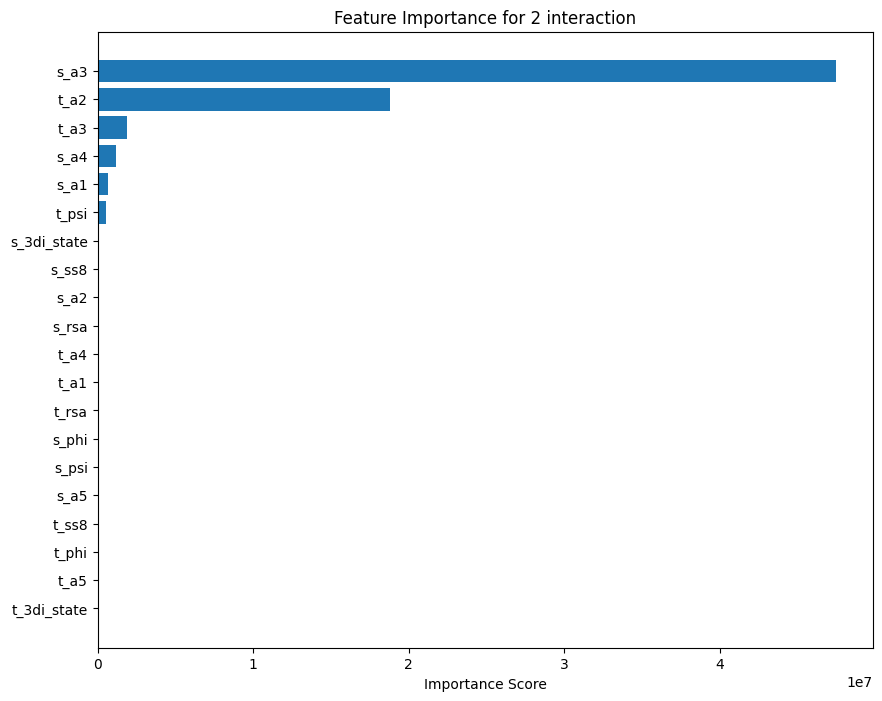

Training classifier for Class 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.968478

Binary Classification Report for Class 3
Accuracy: 0.9227
Balanced Accuracy: 0.9603


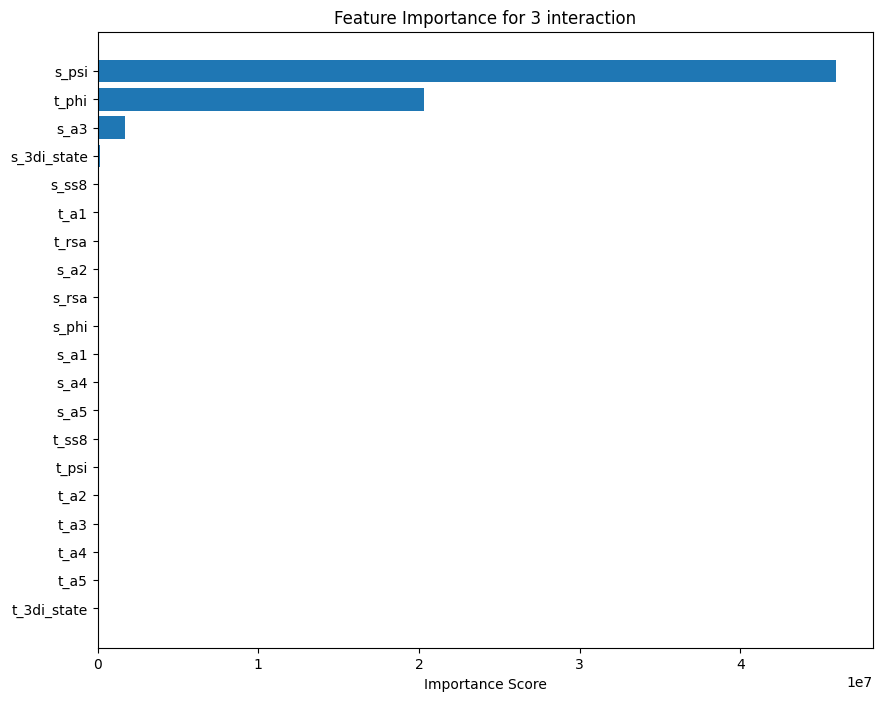

Training classifier for Class 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.949813

Binary Classification Report for Class 4
Accuracy: 0.9003
Balanced Accuracy: 0.9500


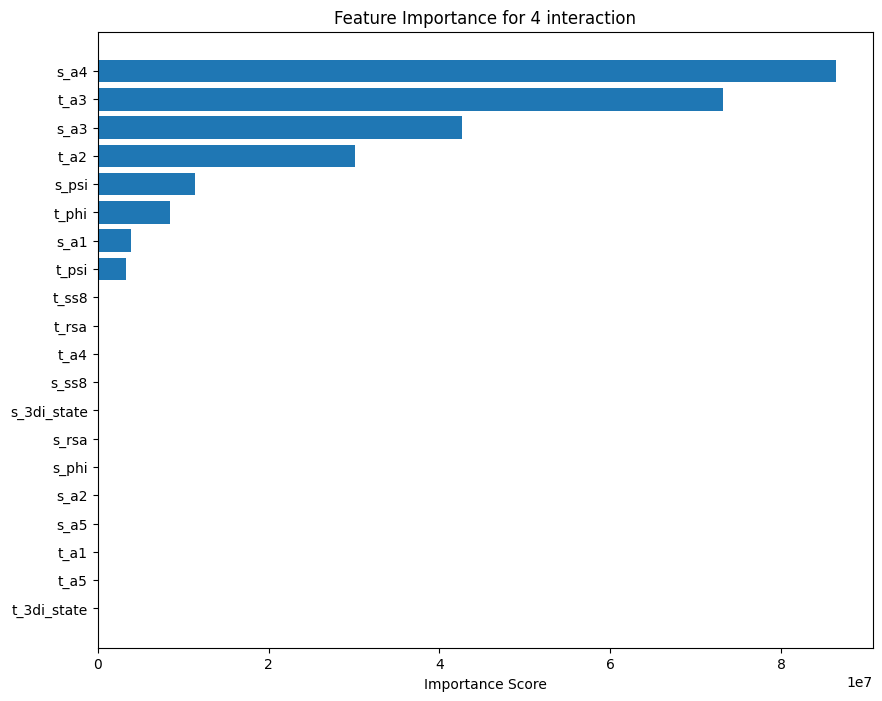

Training classifier for Class 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.999529

Binary Classification Report for Class 5
Accuracy: 0.9988
Balanced Accuracy: 0.9994


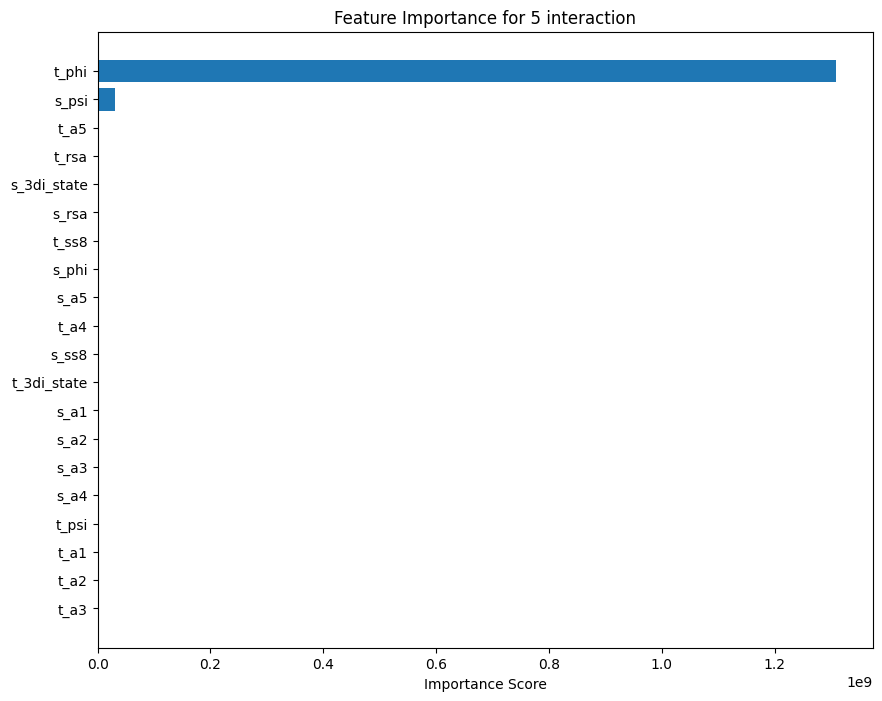

Training classifier for Class 6
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.93352

Binary Classification Report for Class 6
Accuracy: 0.6771
Balanced Accuracy: 0.8343


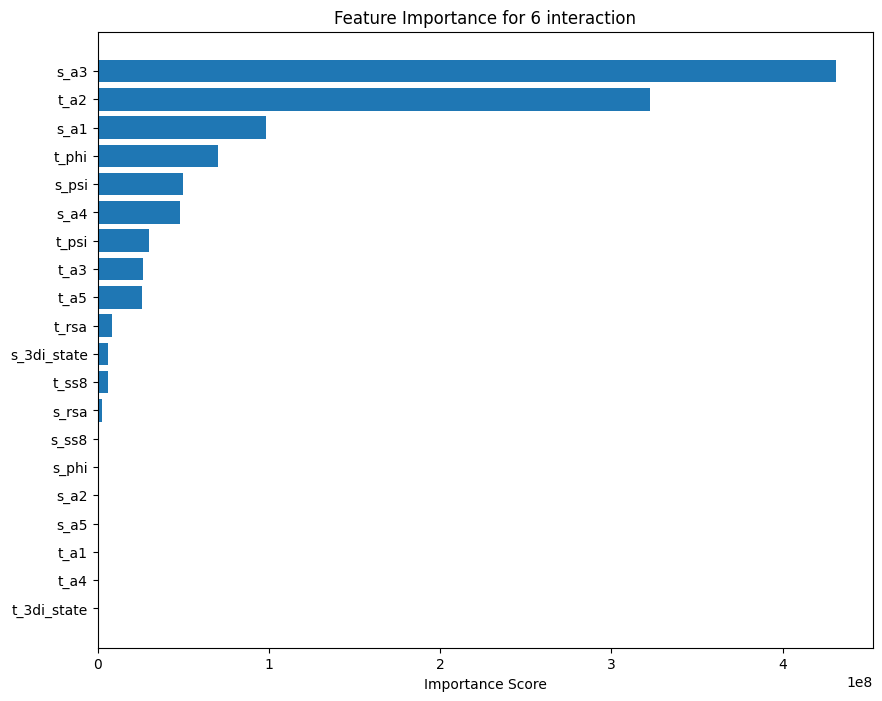

Training classifier for Class 7
Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.695526
[100]	valid_0's auc: 0.705544
[150]	valid_0's auc: 0.71222
[200]	valid_0's auc: 0.716084
[250]	valid_0's auc: 0.71924
[300]	valid_0's auc: 0.721394
[350]	valid_0's auc: 0.72343
[400]	valid_0's auc: 0.725062
[450]	valid_0's auc: 0.726876
[500]	valid_0's auc: 0.728437
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.728437

Binary Classification Report for Class 7
Accuracy: 0.6667
Balanced Accuracy: 0.6654


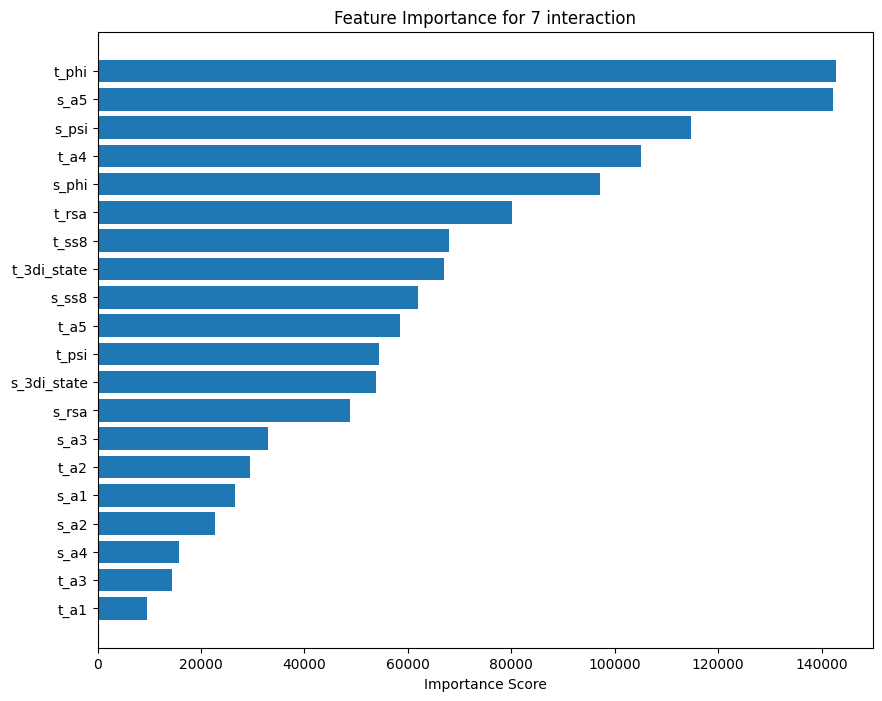

In [26]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))  # y_bal

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):  # y_bal
    print(f'Training classifier for Class {num_class}')

    # Create binary labels
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)
    y_test_binary = (y_test == num_class).astype(int)

    # Skip if no positive examples in training
    if np.sum(y_train_binary) == 0:
        print(f"No positive examples for class {num_class}, skipping...")
        all_class_predictions[:, num_class] = 0  # Default to negative prediction
        continue

    # Create LightGBM datasets
    try:
        train_data = lgb.Dataset(X_train, label=y_train_binary)
        val_data = lgb.Dataset(X_val, label=y_val_binary, reference=train_data)

        # Count class distribution
        pos_class = np.sum(y_train_binary == 1)
        neg_class = np.sum(y_train_binary == 0)
        scale_pos_weight = neg_class / pos_class if pos_class > 0 else 1.0

        # More robust parameters
        params = {
            'device': 'cpu',  # Try CPU first to isolate GPU issues
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': 8,  # Reduced from 10
            'learning_rate': 0.2,  # Reduced from 0.2
            'min_child_samples': 20,  # Added to prevent overfitting
            'scale_pos_weight': scale_pos_weight,
            'seed': 42,
            'verbosity': -1,
            'force_row_wise': True  # Helps with small datasets
        }

        # Train with more conservative settings
        model = lgb.train(
            params=params,
            train_set=train_data,
            num_boost_round=500,  # Reduced from 2500
            valid_sets=[val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=20, verbose=True),
                lgb.log_evaluation(50)
            ]
        )

        # Store predictions
        y_pred_prob = model.predict(X_test)
        all_class_predictions[:, num_class] = y_pred_prob

        # Evaluate
        y_pred = (y_pred_prob > 0.5).astype(int)
        print(f"\nBinary Classification Report for Class {num_class}")
        print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
        print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_pred):.4f}")

        # Feature importance
        feature_importance(model, X_train, y_train_binary, num_class)
        models.append(model)

    except Exception as e:
        print(f"Error training class {num_class}: {str(e)}")
        all_class_predictions[:, num_class] = 0  # Default to negative prediction
        models.append(None)  # Placeholder for failed model

# Final multi-class predictions (choose class with highest probability)
# final_predictions = np.argmax(all_class_predictions, axis=1)

# Evaluate overall multi-class performance
# print("\n==== Overall Multi-class Performance ====")
# compute_metrics(y_test, final_predictions, all_class_predictions)
# plot_confusion_matrix(y_test, final_predictions, np.unique(y))